# モジュールのインポート

In [1]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# 必要情報を入力

In [2]:
# 各フォルダの読み込み
# folder_list = glob.glob(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\data\*')
# folder_list = glob.glob(r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\data\*')
folder_list = glob.glob(r'.\input\spectra_data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelファイルの保存先のパス
# excel_path = r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\\'
# excel_path = r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\\'
output_path = r'.\output\\'

# データの読み込み

In [15]:
file_dic = {}
for n, folder in enumerate(folder_list):
    file_dic[f'data_{n+1}'] = glob.glob(folder + '\*')

df_list = []

for folder in file_dic:
    # フォルダ内にファイルがある場合
    if len(file_dic[folder]) > 0:
        # 各種データ保存用のディクショナリを作成
        data_dic = {}

        # テクストファイルの読み込み
        for file in file_dic[folder]:
            # ファイル名の切り取り
            file_name = re.split('[\\\\.]', file)[5]

            # 一時保存用リストの作成
            temp_list = []

            # スペクトルデータの読み込み
            with open(file, encoding='utf-8') as f:
                for row in f:
                    row = row.strip()
                    temp_list.append(re.split(sep, row))
            temp_list = temp_list[32:1069]

            # ディクショナリへデータの格納
            data_dic[file_name] = temp_list

        # 空のデータフレームを作成
        df = pd.DataFrame()

        # フォルダ内データをデータフレームに追加
        for key in data_dic:
            intensity_list = []
            wave_list = []

            for n in range(len(data_dic[key])):
                intensity_list.append(data_dic[key][n][3])

            for n in range(len(data_dic[key])):
                wave_list.append(data_dic[key][n][0])

            df['Raman Shift'] = wave_list
            df[key] = intensity_list

        df = df.astype(float)
        df = df.sort_values(by=['Raman Shift'], ascending=True).reset_index(drop=True)

        df_list.append(df)

    else:
        break

# グラフの可視化

In [16]:
# X軸の最大・最小の設定
XLIM_MIN = 200
XLIM_MAX = 1700
# Y軸の最大・最小の設定
YLIM_MIN = -1000
YLIM_MAX = 10000
# 軸ラベルの設定
XLABEL = 'Raman Shift [cm^-1]'
YLABEL = 'Intensity [a.u.]'
# グラフサイズ
GRAPH_SIZE = (8, 6)
# フォントサイズ
FONTS_SIZE = 14

In [17]:
def show_raman_spectra(spectra_df_list):
    """
    ラマンスペクトルを表示する関数
    :param spectra_df_list: 各スペクトルデータフレームのリスト
    """
    for df in spectra_df_list:
        yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
        plt.figure(figsize=(25, 4))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.plot(df['Raman Shift'] , df[yaxis_list[i*10]])
            plt.title(yaxis_list[i*10])
            plt.xlim(XLIM_MIN, XLIM_MAX)
            plt.ylim(YLIM_MIN, YLIM_MAX)

        # plt.xlabel(XLABEL)
        # plt.ylabel(YLABEL)
        # plt.xticks(fontsize=FONTS_SIZE)
        # plt.yticks(fontsize=FONTS_SIZE)
        plt.tight_layout()
        plt.show()

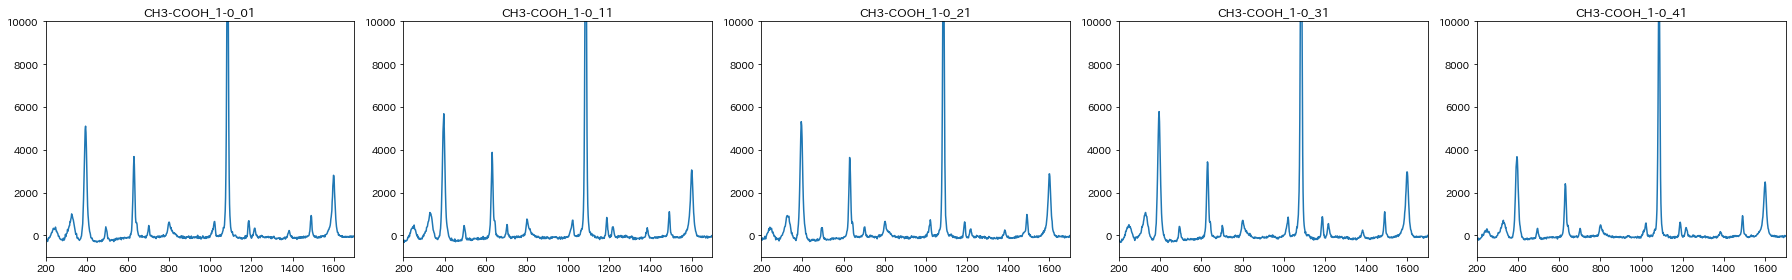

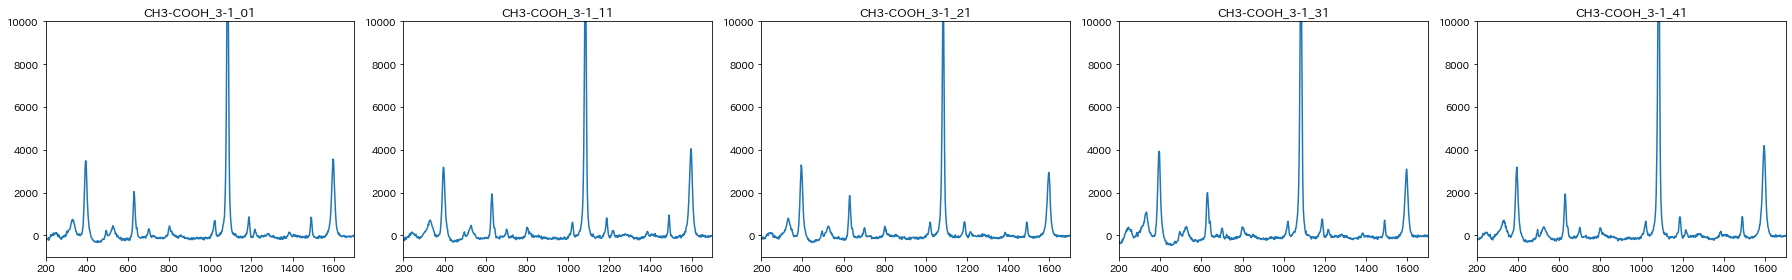

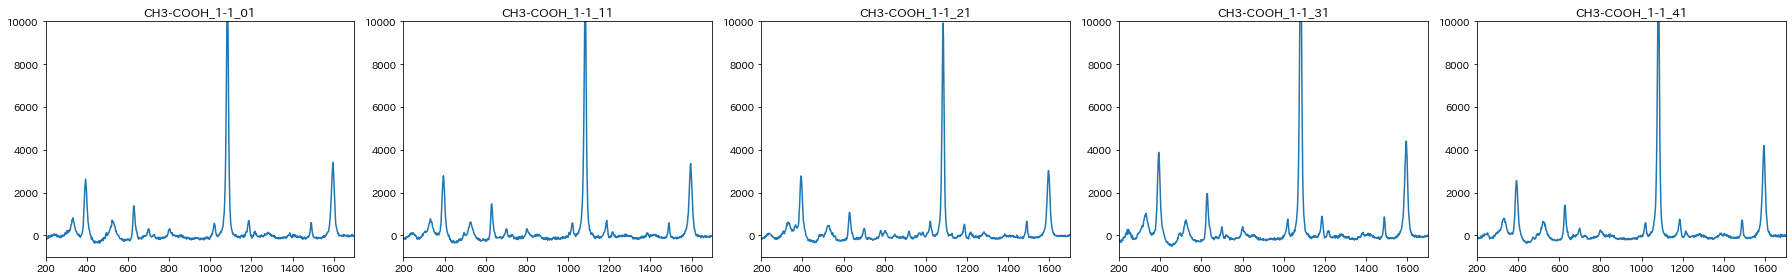

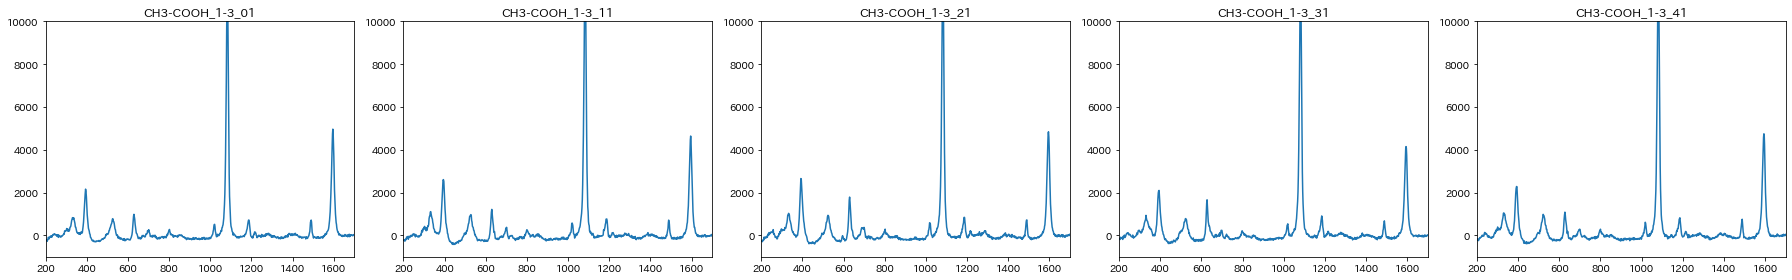

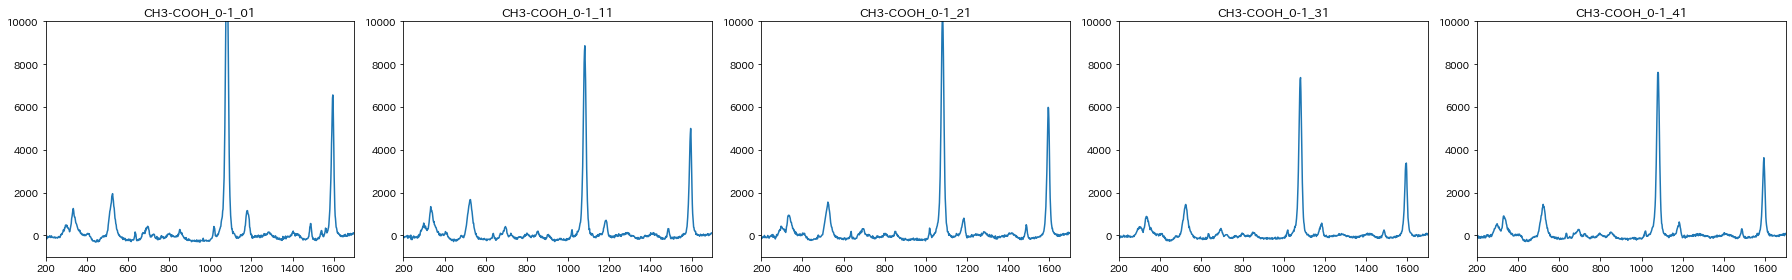

In [18]:
show_raman_spectra(df_list)

# スペクトルデータの正規化

In [19]:
scaled_df_list = []

# 最大強度を1にスケール化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = MinMaxScaler()
    series = scaler.fit_transform(df[yaxis_list])
    scaled_df = pd.DataFrame(series)
    scaled_df.columns = yaxis_list
    scaled_df.insert(0, 'Raman Shift', df['Raman Shift'])

    scaled_df_list.append(scaled_df)

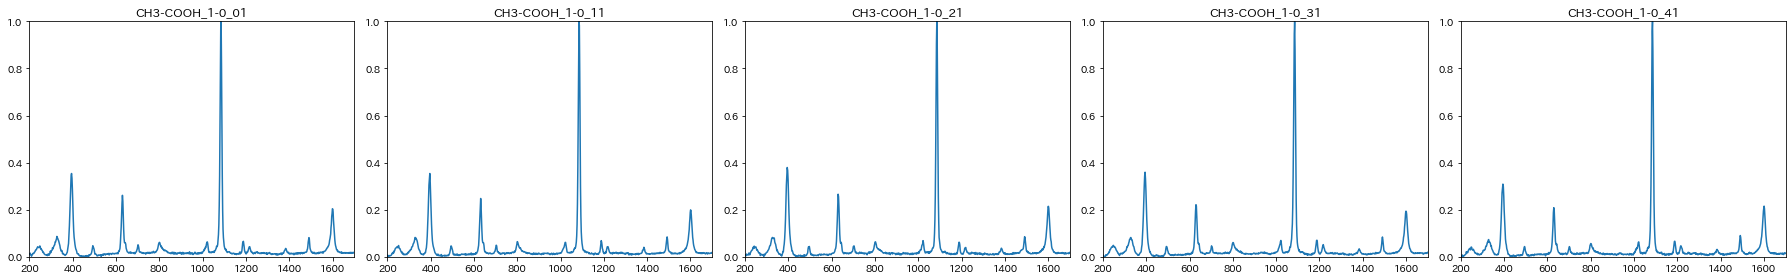

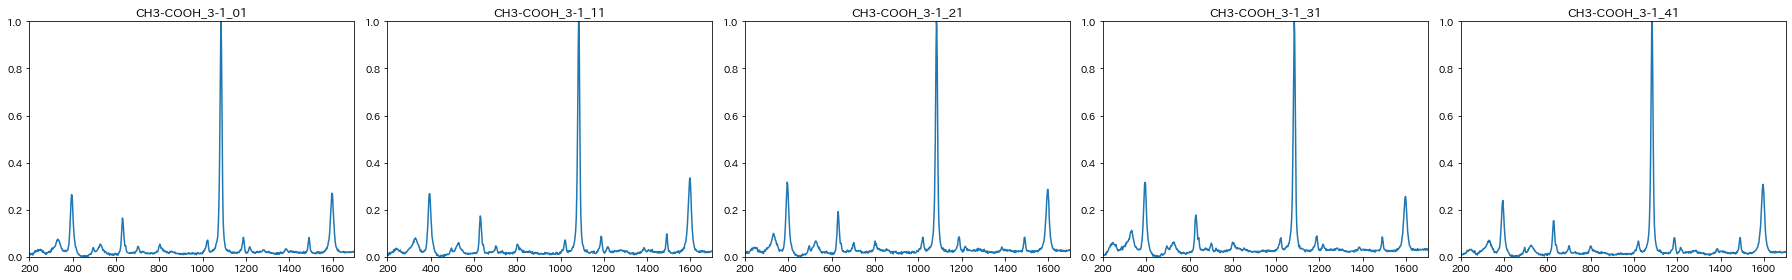

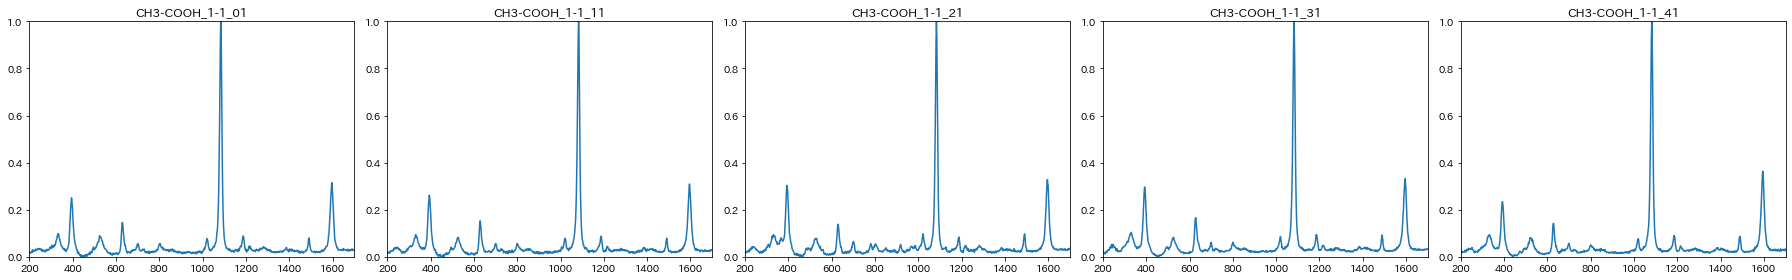

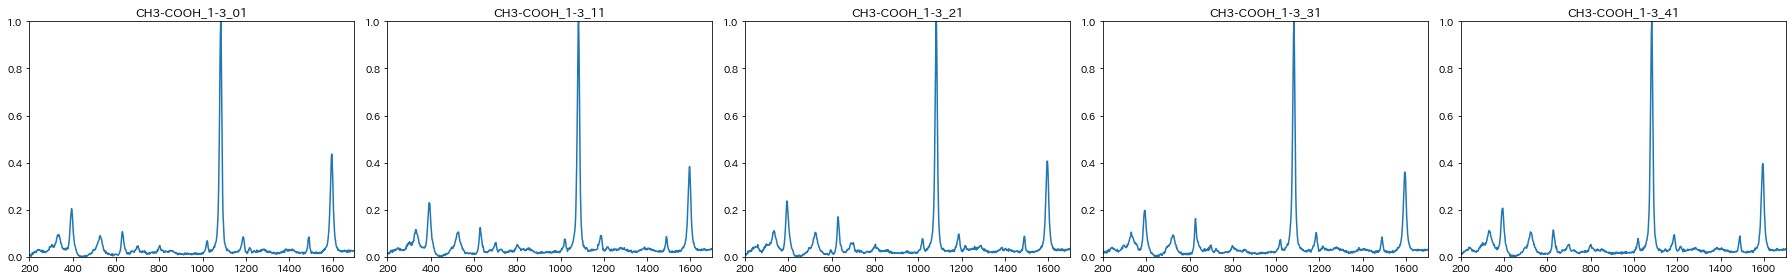

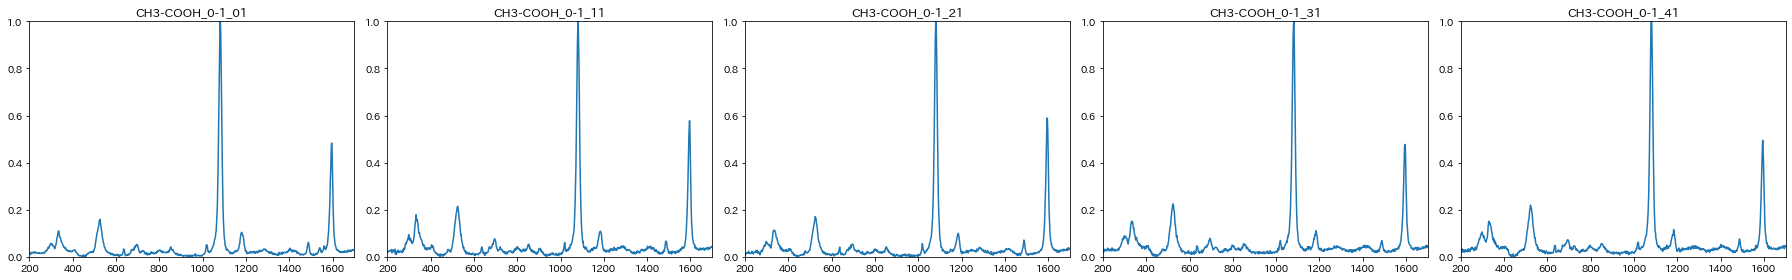

In [20]:
# Y軸の最大・最小の設定
YLIM_MIN = 0
YLIM_MAX = 1

show_raman_spectra(scaled_df_list)

In [21]:
# 解析用にデータフレームの形状を変更
RAMAN_SHIFT = df_list[0]['Raman Shift']
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

for n, df in enumerate(scaled_df_list):
    df.loc[-1] = int(n)

data_df = pd.concat(scaled_df_list, axis=1)
data_df = data_df.drop(['Raman Shift'], axis=1)
data_df = data_df.T
# labelのみ別で保存
data_label = data_df[-1]
# label無しのデータフレーム
data_df = data_df.drop(-1, axis=1)
data_df.columns = RAMAN_SHIFT

# スペクトルデータの標準化（サンプル方向）

In [9]:
std_scaler = StandardScaler()
std_series = std_scaler.fit_transform(data_df)
std_data_df = pd.DataFrame(std_series)
std_data_df.columns = data_df.columns
std_data_df.index = data_df.index

std_data_df.head()

Raman Shift,201.192791,203.237476,205.281480,207.324801,209.367441,211.409400,213.450678,215.491276,217.531194,219.570432,...,1992.873612,1994.360356,1995.846670,1997.332555,1998.818009,2000.303035,2001.787631,2003.271798,2004.755536,2006.238845
CH3-COOH_0-1_01,-0.050482,0.580402,-0.391968,0.467305,0.444443,-0.161731,0.684989,-0.246859,-0.489787,-0.026129,...,-0.315012,-0.290772,-0.316951,-0.284495,-0.229400,-0.317203,-0.449121,-0.323950,-0.314934,-0.110554
CH3-COOH_0-1_02,0.591937,0.688732,1.049257,1.050381,0.848251,-0.026862,-0.171459,0.520172,0.535325,1.316908,...,-0.009982,0.126260,0.311103,0.095479,0.219277,-0.017447,0.179907,-0.058183,-0.035483,0.042024
CH3-COOH_0-1_03,0.220467,-0.174778,0.613234,0.503033,0.108151,0.209753,0.397463,0.040022,0.424299,-0.396391,...,0.044644,-0.047260,-0.031667,0.078541,-0.121955,-0.048551,-0.087970,-0.312262,-0.089956,0.061020
CH3-COOH_0-1_04,-0.641536,-0.301701,-0.657325,-0.197637,-0.327447,-0.983523,-0.640223,-0.080972,-0.677894,-0.725612,...,-0.788998,-0.651340,-0.523581,-0.575532,-0.735206,-0.640502,-0.738382,-0.612354,-0.660792,-0.779423
CH3-COOH_0-1_05,0.069074,-0.256549,0.189824,-0.580504,-1.075430,0.042258,-0.131617,-0.263306,-0.159845,0.116584,...,-0.319601,-0.527256,-0.314105,-0.329486,-0.278867,-0.395003,-0.281682,-0.506968,-0.431713,-0.338617


# データフレームの保存

In [33]:
df_title = 'P100_CH3_COOH_df'
save_df = data_df.copy()
save_df['label'] = data_label
save_df.to_pickle(output_path + df_title + '.pkl')

# PCAによるスペクトルの2次元化

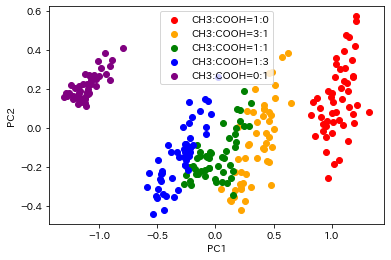

In [22]:
pca = PCA(n_components=2)

X = pca.fit_transform(data_df.values)
pca_result_df = pd.DataFrame(X)
pca_result_df.columns = ['PC1', 'PC2']
pca_result_df['label'] = data_label.values

color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

for i in range(np.unique(data_label).size):
    data = pca_result_df[pca_result_df['label'] == i]
    plt.scatter(data['PC1'], data['PC2'], c=color_list[i], label=label_list[i])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.show()

In [23]:
# 寄与率の算出
df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=['PC1', 'PC2'])
df_exp_var_ratio.head()

,PC1,PC2
0,0.830896,0.074666


<AxesSubplot:xlabel='Raman Shift'>

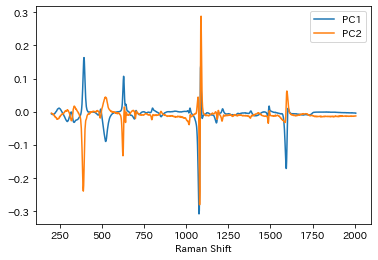

In [24]:
#各主成分の固有ベクトル
pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=['PC1', 'PC2'])
# 固有ベクトルの可視化
pca_vec_df.T.plot()

# PCA_SVM

In [43]:
def pca_svm(n_comp, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

## クロスバリデーションによる評価

In [45]:
# n_components = 2
raitio_2, _, cm_2, accuracy_2 = pca_svm(2, data_df, data_label)
print(raitio_2)
print(accuracy_2)

        PC1       PC2
0  0.754869  0.091071
0.96


<AxesSubplot:>

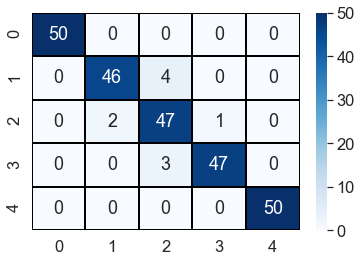

In [46]:
sns.set(font_scale=1.5)
sns.heatmap(cm_2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [47]:
# n_components = 3
raitio_3, _, cm_3, accuracy_3 = pca_svm(3, data_df, data_label)
print(raitio_3)
print(accuracy_3)

        PC1       PC2       PC3
0  0.754869  0.091071  0.050992
0.964


<AxesSubplot:>

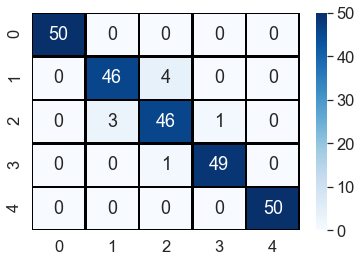

In [48]:
sns.set(font_scale=1.5)
sns.heatmap(cm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [44]:
# train_accuracy計算用
def train_pca_svm(n_comp, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC()
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)


    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

In [49]:
# train_accuracy
train_raitio_n, _, train_cm_n, train_accuracy_n = train_pca_svm(3, data_df, data_label)
print(train_raitio_n)
print(train_accuracy_n)

        PC1       PC2       PC3
0  0.754869  0.091071  0.050992
0.964


<AxesSubplot:>

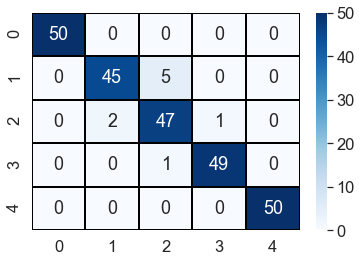

In [50]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_n, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 標準化データによる評価

In [91]:
# 標準化データでの予測
std_raitio_3, _, std_cm_3, std_accuracy_3 = pca_svm(3, std_data_df, data_label)
print(std_raitio_3)
print(std_accuracy_3)

        PC1       PC2       PC3
0  0.440292  0.180613  0.055657
0.82


<AxesSubplot:>

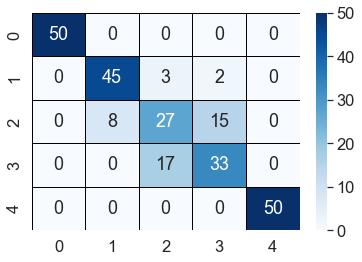

In [92]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [33]:
# n_components = 5
raitio_5, _, cm_5, accuracy_5 = pca_svm(5, data_df, data_label)
print(raitio_5)
print(accuracy_5)

        PC1      PC2       PC3       PC4       PC5
0  0.767717  0.07958  0.051269  0.016162  0.013143
0.964


<AxesSubplot:>

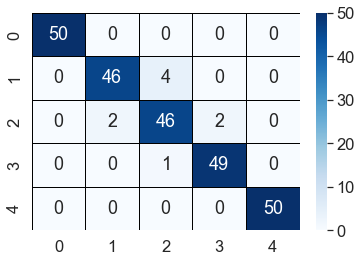

In [34]:
sns.set(font_scale=1.5)
sns.heatmap(cm_5, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# SVM単体での解析

In [51]:
def svm_only(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [52]:
cm_svm, accuracy_svm = svm_only(data_df, data_label)
print('Accuracy:', accuracy_svm)

Accuracy: 0.832


<AxesSubplot:>

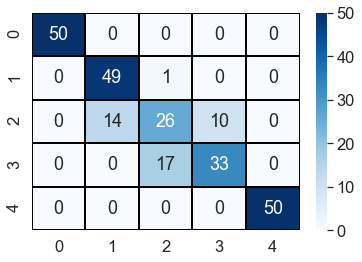

In [53]:
sns.set(font_scale=1.5)
sns.heatmap(cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 学習データによる評価

In [54]:
def train_svm_only(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = SVC()
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [55]:
train_cm_svm, train_accuracy_svm = train_svm_only(data_df, data_label)
print('Accuracy:', train_accuracy_svm)

Accuracy: 0.944


<AxesSubplot:>

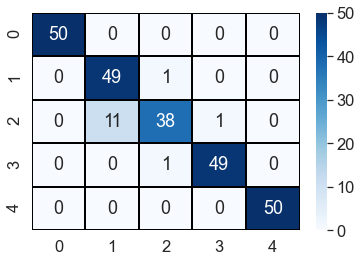

In [56]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 標準化データによる評価

In [93]:
# 標準化データでの予測
std_cm_svm, std_accuracy_svm = svm_only(std_data_df, data_label)
print('Accuracy:', std_accuracy_svm)

Accuracy: 0.876


<AxesSubplot:>

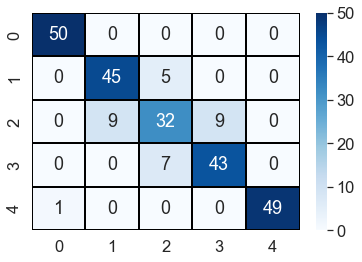

In [175]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Linear Discriminant Analysis(LDA)

## スペクトルの2次元化

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


explained variance ratio (first two components): [0.92877314 0.06630341]


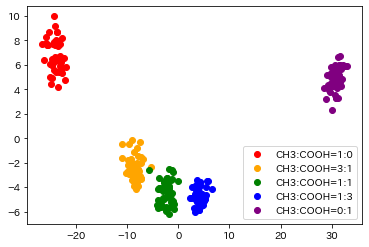

In [25]:
lda = LDA(n_components=2)
X_r2 = lda.fit(data_df, data_label).transform(data_df)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

for i in range(np.unique(data_label).size):
    plt.scatter(X_r2[data_label == i, 0], X_r2[data_label == i, 1],
    c=color_list[i], label=label_list[i])

plt.legend(loc='best')
plt.show()

In [26]:
# データ保存用のデータフレームを作成
lda_result_df = pd.DataFrame(X_r2)
lda_result_df.columns = ['LDA1', 'LDA2']
lda_result_df['label'] = data_label.values
lda_result_df.head()

,LDA1,LDA2,label
0,-23.548023,7.511156,0.0
1,-25.302476,8.688200,0.0
2,-25.859767,7.800712,0.0
3,-23.148311,5.480899,0.0
4,-23.963463,5.385000,0.0


## クロスバリデーションによる評価

In [63]:
def lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        lda_model = LDA(n_components=n_comp)
        lda_model.fit(train_x, train_y)
        y_pred = lda_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [64]:
cm_lda2, accuracy_lda2 = lda_prediction(2, data_df, data_label)
print('Accuracy:', accuracy_lda2)

Accuracy: 0.968


<AxesSubplot:>

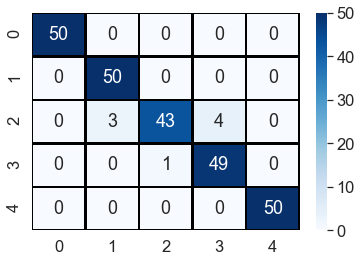

In [65]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda2, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

In [66]:
cm_lda3, accuracy_lda3 = lda_prediction(3, data_df, data_label)
print('Accuracy:', accuracy_lda3)

Accuracy: 0.968


<AxesSubplot:>

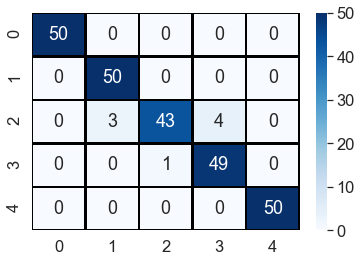

In [67]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda3, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [68]:
def train_lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label

    lda_model = LDA(n_components=n_comp)
    lda_model.fit(X, y)
    y_pred = lda_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [70]:
train_cm_ldan, train_accuracy_ldan = train_lda_prediction(2, data_df, data_label)
print('Accuracy:', train_accuracy_ldan)

Accuracy: 0.992


<AxesSubplot:>

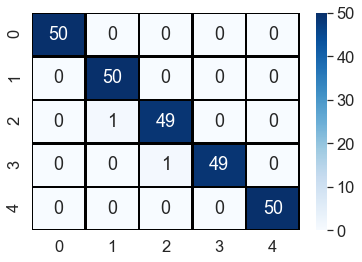

In [71]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_ldan, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

In [95]:
# 標準化データでの予測
std_cm_lda2, std_accuracy_lda2 = lda_prediction(2, std_data_df, data_label)
print('Accuracy:', std_accuracy_lda2)

Accuracy: 0.952


<AxesSubplot:>

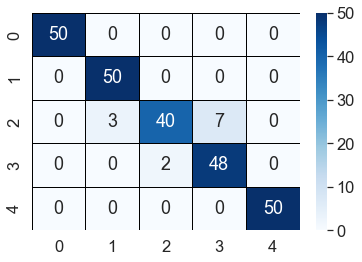

In [96]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_lda2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# t-SNEによるスペクトルの2次元化

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


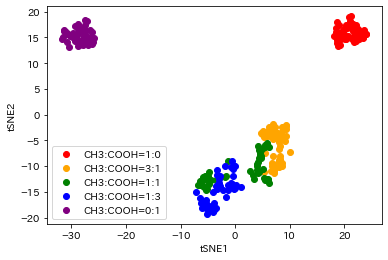

In [27]:
tsne = TSNE(n_components=2, random_state=0, init='pca')

X = tsne.fit_transform(data_df.values)
tsne_result_df = pd.DataFrame(X)
tsne_result_df.columns = ['tSNE1', 'tSNE2']
tsne_result_df['label'] = data_label.values

color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

for i in range(np.unique(data_label).size):
    data = tsne_result_df[tsne_result_df['label'] == i]
    plt.scatter(data['tSNE1'], data['tSNE2'], c=color_list[i], label=label_list[i])

plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.legend(loc='best')
plt.show()

# t-SNE_SVM

In [73]:
def tsne_svm(n_comp, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [74]:
# componet=2
cm_tsne_svm, accuracy_tsne_svm = tsne_svm(2, data_df, data_label)
print('Accuracy:', accuracy_tsne_svm)

Accuracy: 0.92


<AxesSubplot:>

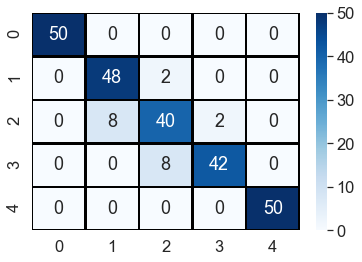

In [75]:
sns.set(font_scale=1.5)
sns.heatmap(cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

In [79]:
# componet=3
cm_tsne_svm_3, accuracy_tsne_svm_3 = tsne_svm(3, data_df, data_label)
print('Accuracy:', accuracy_tsne_svm_3)

Accuracy: 0.712


<AxesSubplot:>

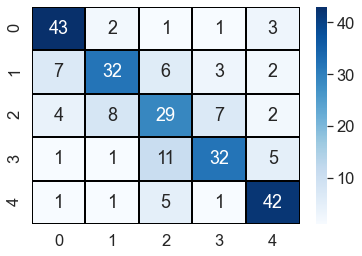

In [80]:
sns.set(font_scale=1.5)
sns.heatmap(cm_tsne_svm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 標準化データによる評価

In [100]:
# 標準化データでの予測
# componet=2
std_cm_tsne_svm, std_accuracy_tsne_svm = tsne_svm(2, std_data_df, data_label)
print('Accuracy:', std_accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.72


## 学習データによる評価

In [76]:
def train_tsne_svm(n_comp, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC()
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [77]:
# componet=2
train_cm_tsne_svm, train_accuracy_tsne_svm = train_tsne_svm(2, data_df, data_label)
print('Accuracy:', train_accuracy_tsne_svm)

Accuracy: 0.96


<AxesSubplot:>

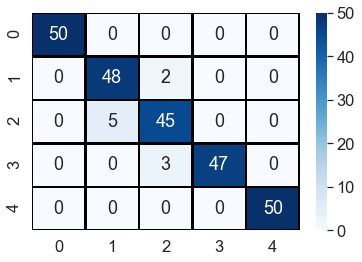

In [78]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# 決定木

## クロスバリデーションによる評価

In [81]:
def decision_tree(data_df, label, max_depth):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                          min_samples_split=2,
                                          min_samples_leaf=1,
                                          max_leaf_nodes=None,
                                          random_state=1234)

        dt_model.fit(train_x, train_y)
        y_pred = dt_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [82]:
max_depth = 5
cm_dt, accuracy_dt = decision_tree(data_df, data_label, max_depth)
print('Accuracy:', accuracy_dt)

Accuracy: 0.92


<AxesSubplot:>

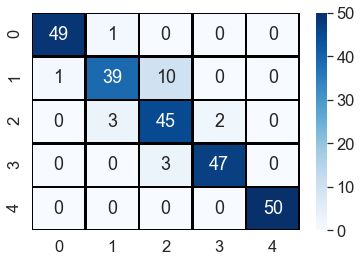

In [83]:
sns.set(font_scale=1.5)
sns.heatmap(cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [84]:
def train_decision_tree(data_df, label, max_depth):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        max_leaf_nodes=None,
                                        random_state=1234)

    dt_model.fit(X, y)
    y_pred = dt_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [85]:
max_depth = 5
train_cm_dt, train_accuracy_dt = train_decision_tree(data_df, data_label, max_depth)
print('Accuracy:', train_accuracy_dt)

Accuracy: 0.988


<AxesSubplot:>

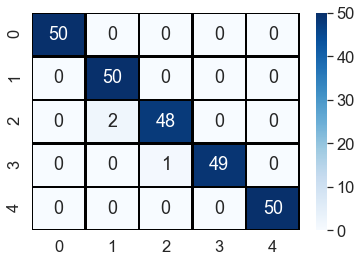

In [86]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# MLPによるクラスタリング

In [19]:
def MLP(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        MLP_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                                  activation='logistic', # logistic, tanh, relu
                                  solver='adam',
                                  max_iter=1000,
                                  random_state=1234)

        MLP_model.fit(train_x, train_y)
        y_pred = MLP_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [20]:
cm_MLP, accuracy_MLP= MLP(data_df, data_label)
print('Accuracy:', accuracy_MLP)

Accuracy: 0.9866666666666667


<AxesSubplot:>

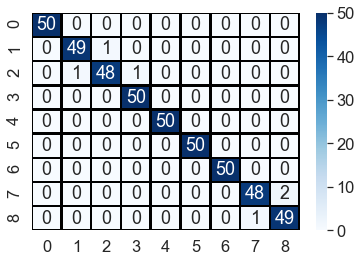

In [21]:
sns.set(font_scale=1.5)
sns.heatmap(cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

In [148]:
# 標準化データでの予測
std_cm_MLP, std_accuracy_MLP = MLP(std_data_df, data_label)
print('Accuracy:', std_accuracy_MLP)

Accuracy: 0.924


## 学習データによる評価

In [55]:
def train_MLP(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    MLP_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                                activation='logistic',
                                solver='adam',
                                max_iter=1000,
                                random_state=1234)

    MLP_model.fit(X, y)
    y_pred = MLP_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [56]:
train_cm_MLP, train_accuracy_MLP = MLP(data_df, data_label)
print('Accuracy:', train_accuracy_MLP)

Accuracy: 0.9866666666666667


<AxesSubplot:>

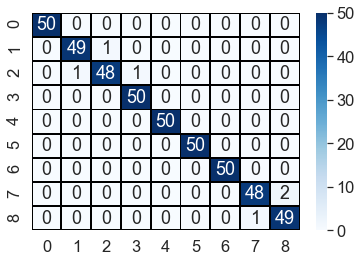

In [57]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# 各データ（スペクトル、PCA、LDA、tSNE）のExcel化

In [28]:
graph_title = 'P100_raw_data_CH3_COOH'

with pd.ExcelWriter(output_path + graph_title + '.xlsx') as writer:
    for n, df in enumerate(df_list):
        df.to_excel(writer, sheet_name=f'data_{n+1}', index=False)

In [29]:
graph_title = 'pca_result'
pca_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [30]:
graph_title = 'vector'
pca_vec_df.T.to_excel(output_path + graph_title + '.xlsx', index=False)

In [31]:
graph_title = 'lda_result'
lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [32]:
graph_title = 'tsne_result'
tsne_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)